In [1]:
from torch_rnn import train, RNN, process_data, randomTrainingExample, categoryFromOutput
import torch
import torch.nn as nn
import string
import time
import math

[]


In [2]:
file_path = 'data/data/names/*.txt'

In [3]:
category_lines, all_categories, n_categories = process_data(file_path)

In [4]:
print(n_categories)

18


In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [6]:
n_hidden = 128
criterion = nn.NLLLoss()

In [7]:
n_iters = 200000
print_every = 5000
plot_every = 1000

In [8]:
# keep track of losses for plotting

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

In [9]:
def run_loop(init, learning_rate):
    current_loss = 0
    all_losses = []
    rnn = RNN(n_letters, n_hidden, n_categories, init)
    for iter in range(1, n_iters+1):
        category, line, category_tensor, line_tensor = randomTrainingExample(category_lines, all_categories)
        output, loss = train(rnn, criterion, category_tensor, line_tensor, learning_rate)
        current_loss += loss

        # Print ``iter`` number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses, rnn

In [10]:
import itertools

learning_rates =  [5e-4]
inits = ['zeros']
hyper_grid = list(itertools.product(learning_rates, inits))
print(hyper_grid)

[(0.0005, 'zeros')]


In [11]:
losses = {}
rnns = {}
for lr, init in hyper_grid:
    losses[(lr,init)], rnns[(lr,init)] = run_loop(init, lr)

5000 2% (0m 6s) 2.9309 Mingo / German ✗ (Spanish)
10000 5% (0m 14s) 2.8200 Cameron / French ✗ (Scottish)
15000 7% (0m 21s) 2.8815 Leandres / Greek ✗ (French)
20000 10% (0m 28s) 2.8878 Gavalok / Greek ✗ (Czech)
25000 12% (0m 35s) 2.6831 Bandini / Italian ✓
30000 15% (0m 42s) 2.8591 Belo / Spanish ✗ (Portuguese)
35000 17% (0m 49s) 2.5640 Armonni / Italian ✓
40000 20% (0m 56s) 2.9413 Raske / Scottish ✗ (German)
45000 22% (1m 4s) 2.8186 Shon / Scottish ✗ (Korean)
50000 25% (1m 11s) 2.5874 Abasolo / Italian ✗ (Spanish)
55000 27% (1m 18s) 3.0539 Fotiadi / Italian ✗ (Russian)
60000 30% (1m 24s) 1.8347 Sokolowski / Polish ✓
65000 32% (1m 32s) 3.1327 Gottschalk / Polish ✗ (German)
70000 35% (1m 38s) 2.2252 Kassab / Arabic ✓
75000 37% (1m 45s) 1.2939 Tsunoda / Japanese ✓
80000 40% (1m 51s) 2.2638 Morra / Spanish ✗ (Italian)
85000 42% (1m 58s) 1.9191 Forest / French ✓
90000 45% (2m 4s) 2.6027 Aarle / Spanish ✗ (Dutch)
95000 47% (2m 11s) 1.2809 Thao / Chinese ✗ (Vietnamese)
100000 50% (2m 18s) 1.6

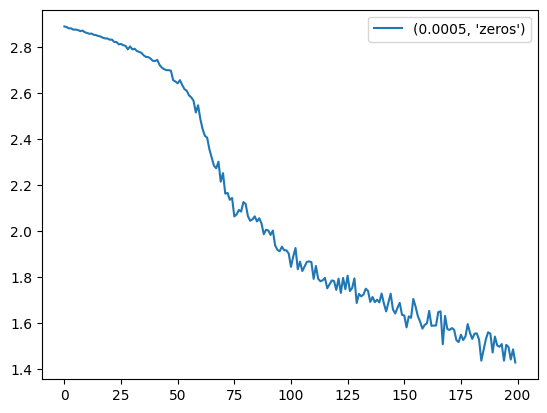

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
for key, val in losses.items():
    plt.plot(val,label=str(key))
plt.legend()
plt.show()

/var/folders/s0/65qv1d5n0qg389zx4z323j_m0000gn/T/ipykernel_69883/1930374456.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/s0/65qv1d5n0qg389zx4z323j_m0000gn/T/ipykernel_69883/1930374456.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


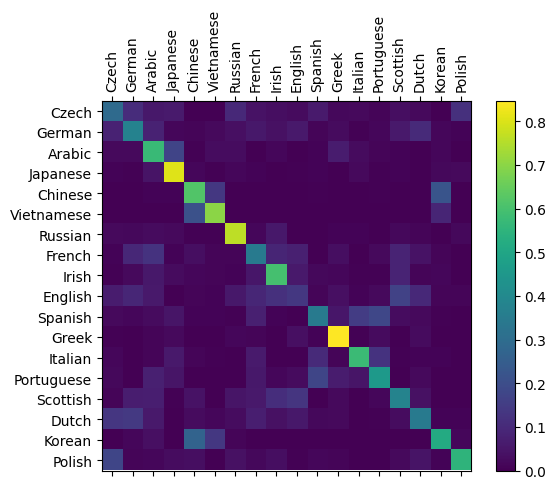

In [17]:
rnn = rnns[(0.0005, 'zeros')]
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(category_lines,all_categories)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output,all_categories)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()